# 2. Обучить алгоритм продолжать последовательность
Последовательности, которые состоят из цифр (от 0 до 9) и задаются следующим образом:

x - последовательность цифр

y1 = x1

yi = xi + x1

Если yi >= 10 то yi = yi - 10

Сгенерируем данные для обучения

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Устройство (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_sequence(seq_length):
    x = np.random.randint(0, 10, seq_length)  
    x1 = x[0]
    y = [(xi + x1) % 10 for xi in x]        
    return x, y

def generate_dataset(num_sequences, seq_length):
    X, Y = [], []
    for _ in range(num_sequences):
        x, y = generate_sequence(seq_length)
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

# Параметры
seq_length = 25       
num_sequences = 7000  

# Генерация данных
X, Y = generate_dataset(num_sequences, seq_length)

# Разделение данных на тренировочную и тестовую выборку
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Подготовим данные

In [4]:
class SequenceDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x = torch.tensor(x_data / 9.0, dtype=torch.float32) 
        self.y = torch.tensor(y_data, dtype=torch.long)       

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# DataLoader
batch_size = 64
train_dataset = SequenceDataset(X_train, Y_train)
test_dataset = SequenceDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Создадим модель. Сделаем ее с возможность выбора RNN

In [5]:
class RNNModel(nn.Module):
    def __init__(self, rnn_type, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size

        if rnn_type == "RNN":
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError("ValueError")
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_out, _ = self.rnn(x) 
        out = self.fc(rnn_out) 
        return out

Напишем функцию для обучения и теста модели

In [6]:
# Функция обучения и тестирования модели
def train_and_evaluate(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    # Функция потерь и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        # === ТРЕНИРОВКА ===
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.unsqueeze(-1).to(device) 
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch) 
            
            loss = criterion(outputs.view(-1, 10), y_batch.view(-1))  
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            _, predicted = torch.max(outputs, -1)  
            train_correct += (predicted == y_batch).sum().item()
            train_total += y_batch.numel() 

        train_accuracy = train_correct / train_total * 100
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / len(train_loader))

        # TEST
        model.eval()
        test_loss = 0
        test_correct = 0 
        test_total = 0

        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.unsqueeze(-1).to(device)
                y_batch = y_batch.to(device)

                outputs = model(x_batch)
                
                # Потери
                loss = criterion(outputs.view(-1, 10), y_batch.view(-1))
                test_loss += loss.item()

                # Точность
                _, predicted = torch.max(outputs, -1)
                test_correct += (predicted == y_batch).sum().item()
                test_total += y_batch.numel()

        test_accuracy = test_correct / test_total * 100 
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss / len(test_loader))

        # LOG
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies

Настроим параметры модели

In [7]:
input_size = 1
hidden_size = 128
output_size = 10
num_layers = 2
num_epochs = 30
learning_rate = 0.001

RNN

In [8]:
rnn_model = RNNModel("RNN", input_size, hidden_size, output_size, num_layers)
rnn_train_losses, rnn_test_losses, rnn_train_accuracies, rnn_test_accuracies = train_and_evaluate(
    rnn_model, train_loader, test_loader, num_epochs, learning_rate
)

Epoch [1/30], Train Loss: 2.2891, Train Accuracy: 10.40%, Test Loss: 2.2787, Test Accuracy: 11.21%
Epoch [2/30], Train Loss: 2.2786, Train Accuracy: 10.41%, Test Loss: 2.2766, Test Accuracy: 10.31%
Epoch [3/30], Train Loss: 2.2775, Train Accuracy: 10.48%, Test Loss: 2.2776, Test Accuracy: 10.55%
Epoch [4/30], Train Loss: 2.2777, Train Accuracy: 10.51%, Test Loss: 2.2784, Test Accuracy: 10.84%
Epoch [5/30], Train Loss: 2.2775, Train Accuracy: 10.77%, Test Loss: 2.2761, Test Accuracy: 10.40%
Epoch [6/30], Train Loss: 2.2769, Train Accuracy: 10.67%, Test Loss: 2.2763, Test Accuracy: 10.70%
Epoch [7/30], Train Loss: 2.2769, Train Accuracy: 10.72%, Test Loss: 2.2762, Test Accuracy: 11.11%
Epoch [8/30], Train Loss: 2.2764, Train Accuracy: 10.79%, Test Loss: 2.2760, Test Accuracy: 10.79%
Epoch [9/30], Train Loss: 2.2762, Train Accuracy: 10.56%, Test Loss: 2.2774, Test Accuracy: 10.42%
Epoch [10/30], Train Loss: 2.2760, Train Accuracy: 10.65%, Test Loss: 2.2763, Test Accuracy: 10.79%
Epoch [11

LSTM

In [9]:
lstm_model = RNNModel("LSTM", input_size, hidden_size, output_size, num_layers)
lstm_train_losses, lstm_test_losses, lstm_train_accuracies, lstm_test_accuracies = train_and_evaluate(
    lstm_model, train_loader, test_loader, num_epochs, learning_rate
)

Epoch [1/30], Train Loss: 2.3011, Train Accuracy: 10.41%, Test Loss: 2.2993, Test Accuracy: 10.70%
Epoch [2/30], Train Loss: 2.2907, Train Accuracy: 10.55%, Test Loss: 2.2775, Test Accuracy: 10.57%
Epoch [3/30], Train Loss: 2.2759, Train Accuracy: 10.51%, Test Loss: 2.2758, Test Accuracy: 10.43%
Epoch [4/30], Train Loss: 2.2753, Train Accuracy: 10.41%, Test Loss: 2.2746, Test Accuracy: 10.26%
Epoch [5/30], Train Loss: 2.2743, Train Accuracy: 10.87%, Test Loss: 2.2735, Test Accuracy: 11.24%
Epoch [6/30], Train Loss: 2.2723, Train Accuracy: 10.53%, Test Loss: 2.2711, Test Accuracy: 10.14%
Epoch [7/30], Train Loss: 2.2704, Train Accuracy: 10.51%, Test Loss: 2.2703, Test Accuracy: 10.47%
Epoch [8/30], Train Loss: 2.2699, Train Accuracy: 10.57%, Test Loss: 2.2699, Test Accuracy: 10.35%
Epoch [9/30], Train Loss: 2.2674, Train Accuracy: 10.81%, Test Loss: 2.2629, Test Accuracy: 10.67%
Epoch [10/30], Train Loss: 2.2138, Train Accuracy: 13.75%, Test Loss: 2.0064, Test Accuracy: 23.08%
Epoch [11

GRU

In [10]:
gru_model = RNNModel("GRU", input_size, hidden_size, output_size, num_layers)
gru_train_losses, gru_test_losses, gru_train_accuracies, gru_test_accuracies = train_and_evaluate(
    gru_model, train_loader, test_loader, num_epochs, learning_rate
)

Epoch [1/30], Train Loss: 2.3021, Train Accuracy: 10.26%, Test Loss: 2.2985, Test Accuracy: 10.15%
Epoch [2/30], Train Loss: 2.2860, Train Accuracy: 10.59%, Test Loss: 2.2767, Test Accuracy: 10.34%
Epoch [3/30], Train Loss: 2.2769, Train Accuracy: 10.72%, Test Loss: 2.2777, Test Accuracy: 10.49%
Epoch [4/30], Train Loss: 2.2760, Train Accuracy: 10.58%, Test Loss: 2.2757, Test Accuracy: 10.66%
Epoch [5/30], Train Loss: 2.2753, Train Accuracy: 10.69%, Test Loss: 2.2761, Test Accuracy: 10.36%
Epoch [6/30], Train Loss: 2.2747, Train Accuracy: 10.76%, Test Loss: 2.2748, Test Accuracy: 10.95%
Epoch [7/30], Train Loss: 2.2738, Train Accuracy: 10.66%, Test Loss: 2.2727, Test Accuracy: 10.12%
Epoch [8/30], Train Loss: 2.2718, Train Accuracy: 10.03%, Test Loss: 2.2689, Test Accuracy: 12.20%
Epoch [9/30], Train Loss: 2.0471, Train Accuracy: 22.04%, Test Loss: 1.5385, Test Accuracy: 47.86%
Epoch [10/30], Train Loss: 1.1054, Train Accuracy: 68.87%, Test Loss: 0.7834, Test Accuracy: 86.37%
Epoch [11

Напишем функцию для построения графиков и посмотрим графики лоса и акураси

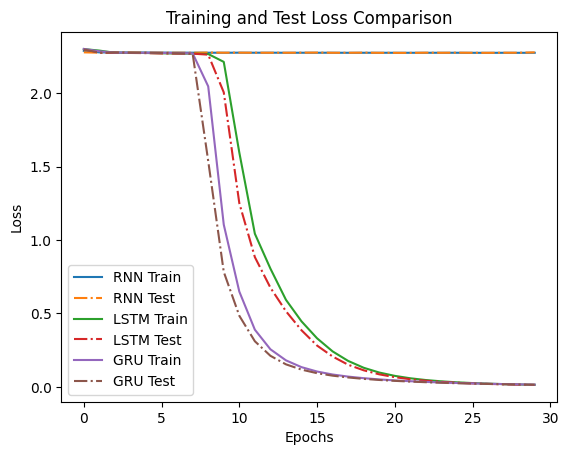

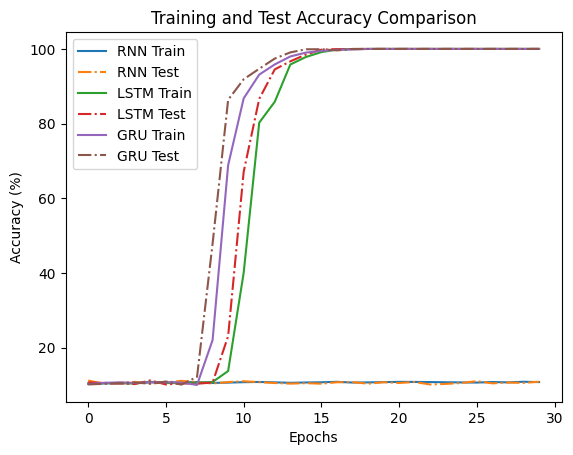

In [11]:
def plot_metrics(train_values, test_values, ylabel, title):
    plt.plot(train_values[0], label="RNN Train")
    plt.plot(test_values[0], '-.', label="RNN Test")
    plt.plot(train_values[1], label="LSTM Train")
    plt.plot(test_values[1], '-.', label="LSTM Test")
    plt.plot(train_values[2], label="GRU Train")
    plt.plot(test_values[2], '-.', label="GRU Test")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Графики потерь
plot_metrics(
    [rnn_train_losses, lstm_train_losses, gru_train_losses], 
    [rnn_test_losses, lstm_test_losses, gru_test_losses],
    ylabel="Loss", 
    title="Training and Test Loss Comparison"
)

# Графики точности
plot_metrics(
    [rnn_train_accuracies, lstm_train_accuracies, gru_train_accuracies],
    [rnn_test_accuracies, lstm_test_accuracies, gru_test_accuracies],
    ylabel="Accuracy (%)",
    title="Training and Test Accuracy Comparison"
)

## Выводы:
1. Модель RNN роказала себя не доолжным образом. Train Loss снижалс очень медленно, а в конце вообще начал расти... Train Accuracy не поднялся выше 10-11%. Это нам говорит о том, что модель плохо обучается и не может извлечь полезную информацию из данных.

2. Модель LSTM сначала показывала себя не очень, но с 11-12 эпохи, Loss стал стремительно уменьшаться, а точность - возрастать. Это говорит о том, что LSTM обучаеться и извлекает полезную информацию
   
3. Модель GRU  показала себя лучше всего. Быстрее всех обучается и показывает отличные метрики.